<h1 style="text-align: center">FashionMNIST Image Classification with Pytorch</h1>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from datetime import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
## funciton to calculate width and height of convolution layer
def conv_out_dim(shape_in, padding=[0,0], dialation=[1,1], kernel_size=[2,2], stride=[1,1]):
#     dim = 0
    dimensions = []
    for dim in range(2):
        dimension = (shape_in[dim]+2*padding[dim]-dialation[dim]*(kernel_size[dim]-1)-1)/stride[dim] + 1
        dimensions.append(math.floor(dimension))
    return dimensions

In [3]:
# out1 = conv_out_dim([28,28], kernel_size=[3,3], stride=[2,2])
# out2 = conv_out_dim(out1, kernel_size=[3,3], stride=[2,2])
# out3 = conv_out_dim(out2, kernel_size=[3,3], stride=[2,2])
# out3

In [4]:
train_dataset = torchvision.datasets.FashionMNIST(
    root=".",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

In [5]:
test_dataset = torchvision.datasets.FashionMNIST(
    root=".",
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [6]:
## inspecting the data
print("Max Pixel Value:", train_dataset.data.max().item())
print("Min Pixel Value:", train_dataset.data.min().item())
print("Dimension of Image:", train_dataset.data[0].shape)
print("Target Values:",train_dataset.targets.unique())

Max Pixel Value: 255
Min Pixel Value: 0
Dimension of Image: torch.Size([28, 28])
Target Values: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [7]:
## Creating CNN
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
                                         nn.ReLU()
                                        )
        
        self.dense_layers = nn.Sequential(nn.Dropout(0.2),
                                          nn.Linear(2*2*128, 512),
                                          nn.ReLU(),
                                          nn.Dropout(0.2),
                                          nn.Linear(512, K)
                                         )
    
    ## overriding forward function
    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

In [8]:
## creating model, criterion and optimizer
model = CNN(train_dataset.targets.unique().size(0))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [149]:
## building loaders for data
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True
                                     )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                     batch_size=batch_size,
                                     shuffle=False
                                    )

In [126]:
## training loop

def train_model(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = []
    test_losses = []
    for it in range(epochs):
        epoch_start_time = datetime.now()## start time at start of epoch
        model.train() ## for the dropouts layer
        epoch_train_losses = []
        for train_inputs, train_targets in train_loader:
            optimizer.zero_grad()
            train_outputs = model(train_inputs)
            train_loss = criterion(train_outputs, train_targets)
            train_loss.backward()
            optimizer.step()
            epoch_train_losses.append(train_loss.item())
            
        ## average of all epoch train losses
        train_losses.append(np.mean(epoch_train_losses))
            
        model.eval() ## also for the dropout layers
        epoch_test_losses = []
        for test_inputs, test_targets in test_loader:
            test_outputs = model(test_inputs)
            test_loss = criterion(test_outputs, test_targets)
            epoch_test_losses.append(test_loss.item())
            
        ## average of all epoch test losses
        test_losses.append(np.mean(epoch_test_losses))
        
        dt = datetime.now() - epoch_start_time ## running time of epoch
        
        print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss {test_loss:.4f}, Duration{dt}")
        
    return train_losses, test_losses

In [129]:
train_losses, test_losses = train_model(model,
                                        criterion,
                                        optimizer,
                                        train_loader,
                                        test_loader,
                                        10
                                       )

Epoch 1/10, Train Loss: 0.5008, Test Loss0.0922, Duration0:00:37.034124
Epoch 2/10, Train Loss: 0.2988, Test Loss0.2378, Duration0:00:35.461999
Epoch 3/10, Train Loss: 0.3229, Test Loss0.5097, Duration0:00:35.285997
Epoch 4/10, Train Loss: 0.4170, Test Loss0.6783, Duration0:00:35.445004
Epoch 5/10, Train Loss: 0.2191, Test Loss0.2542, Duration0:00:35.520999
Epoch 6/10, Train Loss: 0.2888, Test Loss0.6163, Duration0:00:35.993001
Epoch 7/10, Train Loss: 0.3137, Test Loss0.6253, Duration0:00:36.092999
Epoch 8/10, Train Loss: 0.1898, Test Loss0.2807, Duration0:00:36.236003
Epoch 9/10, Train Loss: 0.1317, Test Loss0.5146, Duration0:00:35.904001
Epoch 10/10, Train Loss: 0.1836, Test Loss0.1220, Duration0:00:36.032008


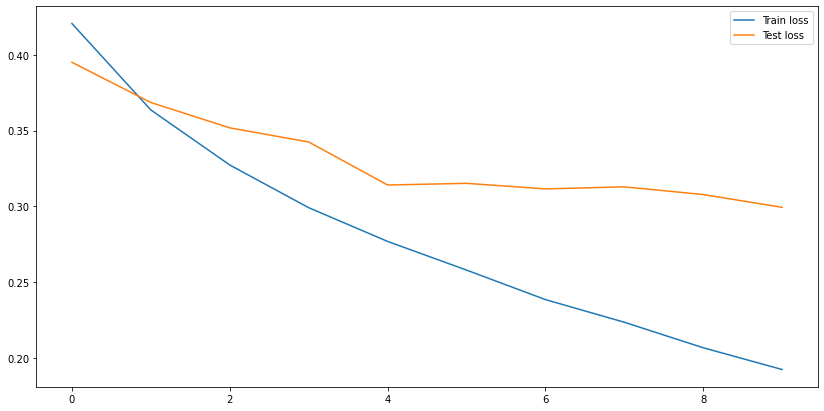

In [136]:
## plotting train and test loss
fig = plt.figure(figsize=(14,7))
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()

In [143]:
## Getting Accuracy

model.eval()

## train accuracy
n_correct = 0
n_targets=0
for inputs, targets in train_loader:
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    n_correct += (preds == targets).sum().item()
    n_targets += targets.shape[0]
    
    train_acc = n_correct/n_targets
    

## test accuracy
n_correct = 0
n_targets=0
for inputs, targets in test_loader:
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    n_correct += (preds == targets).sum().item()
    n_targets += targets.shape[0]
    
    test_acc = n_correct/n_targets
    
print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.9361, Test Accuracy: 0.8955


In [151]:
## making confusion matrix for test data
model.eval()
X_test = test_dataset.data
y_test = test_dataset.targets.numpy()
p_test = np.array([])

for X,y in test_loader:
    preds = model(X)
    _,preds = torch.max(preds, 1)
    p_test=np.concatenate([p_test, preds])

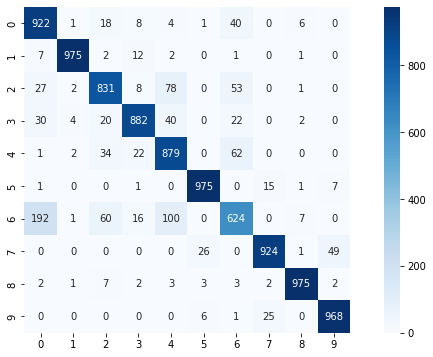

In [152]:
cm = confusion_matrix(y_test,p_test)


fig = plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, square=True, cmap="Blues", fmt="")
plt.show()

In [161]:
labels = train_dataset.classes

In [167]:
labels

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

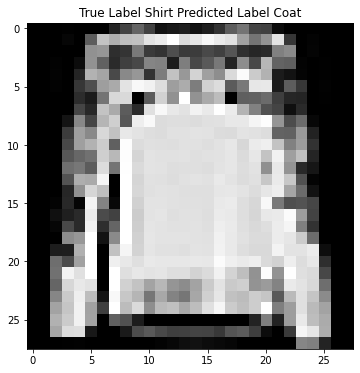

In [189]:
miss_idxs = np.where(y_test != p_test)[0]
i = np.random.choice(miss_idxs)
fig = plt.figure(figsize=(6,6))
plt.title(f"True Label {labels[int(y_test[i])]} Predicted Label {labels[int(p_test[i])]}")
plt.imshow(X_test[i].reshape(28,-1), cmap="gray")
plt.show()